<a href="https://colab.research.google.com/github/FrancescoManca-FM/Project_MLDL/blob/main/Progetto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### GPU

In [1]:
# Check GPU assigned
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Network, dataset, functions and parameters

### LIBRARIES

In [2]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms

from PIL import Image
from tqdm import tqdm
import random


import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.metrics import confusion_matrix

### Resnet32

In [3]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo

"""
Credits to @hshustc
Taken from https://github.com/hshustc/CVPR19_Incremental_Learning/tree/master/cifar100-class-incremental
"""

import math
from torch.nn import init
import torch
import torch.nn as nn

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, use_relu=False):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.stride = stride
        self.use_relu = use_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual

        if self.use_relu:
            out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class Downsample(nn.Module):
    def __init__(self, nIn, nOut, stride):
        super(Downsample, self).__init__()
        assert stride == 2
        self.avg = nn.AvgPool2d(kernel_size=1, stride=stride)

    def forward(self, x):
        x = self.avg(x)
        return torch.cat((x, x.mul(0)), 1)


class CifarResNet(nn.Module):

    def __init__(self, block=BasicBlock, depth=32, num_classes=0, channels=3):

        super(CifarResNet, self).__init__()

        # Model type specifies number of layers for CIFAR-10 and CIFAR-100 model
        assert (depth - 2) % 6 == 0, 'depth should be one of 20, 32, 44, 56, 110'
        layer_blocks = (depth - 2) // 6
        bn = nn.BatchNorm2d
        self.inplanes = 16

        self.conv_1_3x3 = nn.Conv2d(channels, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn_1 = bn(self.inplanes)

        self.stage_1 = self._make_layer(block, 16, layer_blocks, 1)
        self.stage_2 = self._make_layer(block, 32, layer_blocks, 2)
        self.stage_3 = self._make_layer(block, 64, layer_blocks, 2, last=True)
        self.avgpool = nn.AvgPool2d(8)
        self.relu = nn.ReLU()
        #self.linear = nn.Linear(64, num_classes)
        self.fcs = nn.ModuleList([nn.Linear(64, num_classes)])

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, math.sqrt(1. / 64.))
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1, last=False):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = Downsample(self.
inplanes, planes * block.expansion, stride)

        layers = [block(self.inplanes, planes, stride, downsample)]

        self.inplanes = planes * block.expansion

        if last:
            for i in range(1, blocks - 1):
                layers.append(block(self.inplanes, planes))

            layers.append(block(self.inplanes, planes, use_relu=False))

        else:
            for i in range(1, blocks):
                layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):

        x = self.conv_1_3x3(x)

        x = self.bn_1(x)
        x = self.relu(x)

        x = self.stage_1(x)
        x = self.stage_2(x)
        x = self.stage_3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)

        return x

    def predict(self, x):
        out = []
        for fc in self.fcs:
            out.append(fc(x))
        out = torch.cat(out, dim=1)
        return out

    def addOutputNodes(self, num_classes):
        self.fcs.append(nn.Linear(64, num_classes))

### Cifar100

In [4]:
# ref:
# https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py
# https://pytorch.org/docs/stable/_modules/torchvision/datasets/cifar.html#CIFAR10
# homework2 (caltech)

from torchvision.datasets import VisionDataset
from PIL import Image

import os
import os.path
import numpy as np
import pandas as pd
import pickle
import random

from torch.autograd import Variable

# This is an handler class for the Cifar dataset
class CIFAR100(VisionDataset):
    """
    `CIFAR100 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.
    This is a subclass of the `CIFAR100` Dataset.
    """
    base_folder = 'cifar-100-python'
    train_file = 'train'
    test_file = 'test'
    meta_file = 'meta'

    def __init__(self, root, split = 'train', transform = None):
        """
          Args:
              root (string): Root directory of the dataset where directory
                  cifar-100-python exists.
              split (string, optional): If 'train', creates dataset from training
                  set, otherwise creates from test set.
              transform (callable, optional): A function/transform that takes in a
                  PIL image and returns a transformed version.
        """
        super(CIFAR100, self).__init__(root, transform=transform)

        self.split = split
        if split == 'train':
            filename = self.train_file
        else:
            filename = self.test_file

        data_path = os.path.join(self.root, self.base_folder, filename)
        data = None
        labels = None

        with open(data_path, 'rb') as f:
            entry = pickle.load(f, encoding='latin1')
            data = entry['data']
            labels = entry['fine_labels']
        
        data = np.vstack(data).reshape(-1, 3, 32, 32)
        data = data.transpose((0, 2, 3, 1))  # Convert to HWC
        
        labels = np.array(labels)

        self.df = pd.DataFrame()
        self.df['data'] = pd.Series(list(data))
        self.df['labels'] = labels

        self.data = self.df['data']
        self.labels = self.df['labels']

        self._load_meta()

    def _load_meta(self):
        meta_path = os.path.join(self.root, self.base_folder, self.meta_file)
        with open(meta_path, 'rb') as f:
            meta = pickle.load(f, encoding='latin1')
            self.label_names = meta['fine_label_names']

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.df.loc[index, 'data'], self.df.loc[index, 'labels']

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img) # Return a PIL image

        if self.transform is not None:
            img = self.transform(img)

        return index, img, target
    def __len__(self):
        return len(self.data)


    def getTargets(self):
        return set(self.labels)
     
    # test
    def get_indices(self, labels):
        return list(self.df[self.df['labels'].isin(labels)].index)

    def split_classes(self, n_splits=10, seed=None, dictionary_of='dataframes'):
        if dictionary_of not in ['dataframes','indices']:
            raise ValueError("'dictionary_of' must be equal to 'dataframes' or 'indices'")

        all_classes = list(self.df['labels'].value_counts().index)
        dictionary = {}
        random.seed(seed)
        random.shuffle(all_classes)
        split_size = int(len(all_classes)/n_splits)
        for j in range(n_splits):
            if ((j+1)*split_size < len(all_classes)):
                split_end = (j+1)*split_size
            else:
                split_end = None
            subgroup = all_classes[j*split_size:split_end]
            if dictionary_of == 'dataframes':
                dictionary[j] = self.df[self.df['labels'].isin(subgroup)]
            elif dictionary_of == 'indices':
                dictionary[j] = list(self.df[self.df['labels'].isin(subgroup)].index)
        return dictionary

    def split_groups_in_train_validation(self, groups, ratio=0.5, seed=None):
        groups_train_val = dict()
        for k, subdf in groups.items():
            train_indexes = []
            val_indexes = []
            split_labels = list(subdf['labels'].value_counts().index)
            for l in split_labels:
                indexes_to_sample = list(subdf[subdf['labels'] == l].index)
                random.seed(seed)
                train_samples = random.sample(indexes_to_sample, int(len(indexes_to_sample)*ratio))
                train_indexes = train_indexes + train_samples
                val_indexes = val_indexes + list(set(indexes_to_sample).difference(set(train_samples)))
            groups_train_val[k] = {
                'train': train_indexes,
                'val': val_indexes
            }
        return groups_train_val
    
    def split_in_train_val_groups(self, n_splits=10, ratio=0.5, seed=None):
        groups = self.split_classes(n_splits=n_splits, seed=seed)
        return self.split_groups_in_train_validation(groups, ratio=ratio, seed=seed)

    # given a tensors returns an image (used in exemplars)
    #def tensorToImg(self, tensor):
    #   return Variable(transform(Image.fromarray(img)), volatile=True)


### Reverse Index

In [5]:
import pandas as pd
import numpy as np
import torch

__all__ = ['ReverseIndex']

class ReverseIndex():

    def __init__(self, dataset, splits, device='cuda'):

        self.df = pd.DataFrame(columns=['group', 'labels'])

        for k in splits.keys():
            labels = list(dataset.df.loc[splits[k]['train'],'labels'].value_counts().index)
            group = [k for i in range(len(labels))]
            data = pd.DataFrame(np.array([group, labels]).T, columns=['group', 'labels'])
            self.df = self.df.append(data, ignore_index=True)

        self.df['nodes'] = self.df.index
        self.device = device
    
    def _changeIndex(self, reverse_index, column):
        reverse_index = reverse_index.set_index(column)
        reverse_index[column] = reverse_index.index
        return reverse_index

    def getLabels(self, outputs):
        outs = outputs.cpu().numpy()
        reverse_index = self._changeIndex(self.df, 'nodes')
        labels = reverse_index.loc[outs, 'labels']

        labels = torch.tensor(list(labels))
        return labels.to(self.device)

    def getNodes(self, labels):
        labels = labels.cpu().numpy()
       
        reverse_index = self._changeIndex(self.df, 'labels')

        nodes = reverse_index.loc[labels, 'nodes']

        nodes = torch.tensor(list(nodes))
        return nodes.to(self.device)

    def getGroups(self, distinct=True):
        return self.df['group'].value_counts().index.sort_values()
    
    def getLabelsOfGroup(self, group):
        return self.df.loc[self.df['group'] == group, 'labels']

### utils

In [6]:
from torchvision import transforms
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Subset, DataLoader
import math
from torch.nn.parameter import Parameter
from torch.nn import functional as F
from torch.nn import Module

# These are the default iCaRL hyper-parameters
def getHyperparams():
	dictHyperparams = {
		"LR": 2,
		"MOMENTUM": 0.9,
		"WEIGHT_DECAY": 1e-5,
		"NUM_EPOCHS": 70,
		"MILESTONES": [49, 63],
		"BATCH_SIZE": 128,
		"DEVICE": 'cuda',
		"GAMMA": 0.2,
		"SEED": 66, #use 30, 42, 16
		"LOG_FREQUENCY": 10,
		"NUM_CLASSES": 100
	}
	return dictHyperparams

def getOptimizerScheduler(LR, MOMENTUM, WEIGHT_DECAY, MILESTONES, GAMMA, parameters_to_optimize):
	optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
	scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=MILESTONES, gamma=GAMMA, last_epoch=-1) 
	return optimizer, scheduler

# the mean and the std have been found on the web as mean and std of cifar100
# alternative (realistic): compute mean and std for the dataset
def getTransformations():
	# Define transforms for training phase
	train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), # Randomly flip the image with probability of 0.5
	                                      transforms.Pad(4), # Add padding
	                                      transforms.RandomCrop(32),# Crops a random squares of the image
	                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
	                                      transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)) 
	])
	# Define transforms for the evaluation phase
	eval_transform = transforms.Compose([
	                                      transforms.ToTensor(),
	                                      transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)) 
	])
	return train_transform, eval_transform

# BCEWithLogits = Sigmoid + BCE, is the loss used in iCaRL
def getLossCriterion():
	criterion = nn.BCEWithLogitsLoss(reduction = 'mean') # for classification: Cross Entropy
	return criterion

def computeLoss(criterion, outputs, labels):
	return criterion(outputs, labels)

# support BCE
def _one_hot_encode(labels, n_classes, reverse_index, dtype=None, device='cuda'):
	batch_size = len(labels)
	enconded = torch.zeros(batch_size, n_classes, dtype=dtype, device=device)
	labels=map_to_outputs(labels, reverse_index)
	for i, l in enumerate(labels):
	  enconded[i, l] = 1
	return enconded

def map_to_outputs(labels, reverse_index):
	if reverse_index is None:
	  return labels
	if type(labels) == int:
	  return int(reverse_index.getNodes(torch.tensor([labels])))
	elif type(labels) == torch.Tensor:
		return reverse_index.getNodes(labels)


def plotAccuracyTrend(method, data_plot_line, seed):
	plt.figure(figsize=(20,7))
	accuracyDF=pd.DataFrame(data_plot_line, columns = ['Classes','Accuracy'])
	ax = sns.lineplot(x="Classes", y="Accuracy",data=accuracyDF, marker = 'o')
	ax.minorticks_on()
	ax.set_xticks(np.arange(10,110,10))
	ax.set_xlim(xmin=9, xmax=101)
	ax.set_ylim(ymin=0, ymax=1)
	plt.legend(['Accuracy {}'.format(method)])
	ax.grid(axis='y')
	plt.title("Accuracies against seen classes {} - seed: {}".format(method, seed))
	
	filename = "acc_{}_{}.jpg".format(method, seed) # ex. acc_lwf_30
	plt.savefig(filename, format='png', dpi=300)
	plt.show()

def plotConfusionMatrix(method, confusionMatrixData, seed):
	fig,ax=plt.subplots(figsize=(10,10))
	sns.heatmap(confusionMatrixData,cmap='terrain',ax=ax)
	plt.ylabel('True label')
	plt.xlabel('Predicted label')
	plt.title("Confusion Matrix {} - seed: {}".format(method, seed))

	filename = "cm_{}_{}.jpg".format(method, seed) # ex. cm_lwf_30
	plt.savefig(filename, format='png', dpi=300)
	plt.show()

# Write down the metrics (accuracy trand and confusion matrix)
# this method is a shortcut when perfoming multiple tests with different splits (random_seed)
# and allow us to plot on the same graph the data from multiple models (accuracy)
def writeMetrics(method, seed, accuracies, confusionMatrixData):
  data = {}
  data['accuracies'] = []
  data['cm'] = [] #cm line
  i = 0
  for classes_seen in range(10, 110, 10): #x axis on the plot
    data['accuracies'].append({classes_seen : accuracies[i]}) 
    i += 1

  i = 0
  for class_num in range(0,len(confusionMatrixData)): #rows of the cm
    data['cm'].append({class_num : confusionMatrixData[i].tolist()}) 
    i += 1
  
  # dump to file
  aus = method + '_' + str(seed)
  filename = 'data_{}.json'.format(aus)
  with open(filename, 'w') as f:
    json.dump(data, f)

def joinSubsets(dataset, subsets):
    indices = []
    for s in subsets:
        indices += s.indices
    return Subset(dataset, indices)


# Functions
def addOutputs(net, num):
    net.addOutputNodes(num)

def getResNet32():
    net = CifarResNet()
    # net.fc = nn.Linear(net.fc.in_features, output_size) # embedded in the class

    criterion = getLossCriterion()
    parameters_to_optimize = net.parameters()
    optimizer, scheduler = getOptimizerScheduler(LR, MOMENTUM, WEIGHT_DECAY, MILESTONES, GAMMA, parameters_to_optimize)
    return net, criterion, optimizer, scheduler

def addOutputs(net, num):
    net.addOutputNodes(num)

def getNet():
    return getResNet32()

def getSchedulerOptimizer(net):
    parameters_to_optimize = net.parameters()
    optimizer, scheduler = getOptimizerScheduler(LR, MOMENTUM, WEIGHT_DECAY, MILESTONES, GAMMA, parameters_to_optimize)
    return optimizer, scheduler

### DATA

In [7]:
# Download dataset from the official source and save it into DATA/cifar-100-pyhton
DATA_DIR = 'DATA' # here the dataset will be downloaded

if not os.path.isdir('./{}'.format("$DATA_DIR/cifar-100-python")):
    !wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
    !tar -xf 'cifar-100-python.tar.gz'  
    !mkdir $DATA_DIR
    !mv 'cifar-100-python' "$DATA_DIR/cifar-100-python"
    !rm -rf 'cifar-100-python.tar.gz'

--2021-06-07 15:17:43--  https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169001437 (161M) [application/x-gzip]
Saving to: ‘cifar-100-python.tar.gz’

cifar-100-python.ta 100%[===================>] 161.17M  46.9MB/s    in 3.8s    

2021-06-07 15:17:48 (41.9 MB/s) - ‘cifar-100-python.tar.gz’ saved [169001437/169001437]



### HYPERPARAMETERS

In [8]:
DEVICE = 'cuda'
NUM_CLASSES = 100
BATCH_SIZE = 128 
LR = 0.1         
MOMENTUM = 0.9     
WEIGHT_DECAY = 1e-05
NUM_EPOCHS = 1 
GAMMA = 0.2
LOG_FREQUENCY = 10
MILESTONES = [49,63]
RANDOM_SEED = 1993

### Data preprocessing

In [9]:
train_transform, eval_transform = getTransformations()

### train & test

In [10]:
# Import dataset and apply transformations 
train_dataset = CIFAR100(DATA_DIR, split='train', transform=train_transform)
test_dataset = CIFAR100(DATA_DIR, split='test', transform=eval_transform)

# Check datasets length 
print(len(train_dataset))
print(len(test_dataset))

50000
10000


### SPLIT DATA IN CLASSES

In [11]:
def build_test_splits(dataset, reverse_index):
    splits = dict()
    groups = list(reverse_index.getGroups())
    for g in groups:
        labels_of_groups = reverse_index.getLabelsOfGroup(g)
        indices = list(dataset.df[dataset.df['labels'].isin(labels_of_groups)].index)
        splits[g] = indices
    return splits

In [12]:
# TRAIN / VAL split
train_splits = train_dataset.split_in_train_val_groups(ratio=0.99, seed=RANDOM_SEED)
outputs_labels_mapping = ReverseIndex(train_dataset, train_splits)

# TEST split
test_splits = build_test_splits(test_dataset, outputs_labels_mapping)

In [13]:
train_subsets = []
val_subsets = []
test_subsets = []

for v in train_splits.values():
    train_subs = Subset(train_dataset, v['train'])
    val_subs = Subset(train_dataset, v['val'])
    train_subsets.append(train_subs)
    val_subsets.append(val_subs)

for i in range(0,10):
    v=test_splits[i]
    test_subs = Subset(test_dataset, v)
    test_subsets.append(test_subs)

## Fine tuning

### train, validate, test

In [ ]:
import copy
def train(net, train_dataloader, criterion, optimizer, scheduler, num_classes, group_id, old_net, num_epochs=NUM_EPOCHS):    
    num_classes_till_previous_step = group_id * 10 - 10

    # network to GPU
    net = net.to(DEVICE) 

  
    cudnn.benchmark

    current_step = 0
    # Start iterating over the epochs
    start_time = time.time()
    for epoch in range(num_epochs):
        net.train()
        print('Starting epoch {}/{}, LR = {}'.format(epoch+1, num_epochs, scheduler.get_lr()))

        running_corrects = 0
        running_loss = 0.0
        for _, images, labels in train_dataloader:

            # Bring images and labels to GPU
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Labels encoding 
            labels_enc = _one_hot_encode(labels, num_classes, outputs_labels_mapping)
            labels = outputs_labels_mapping.getNodes(labels)

            optimizer.zero_grad()

            # Forward pass
            features = net.forward(images)
            outputs = net.predict(features)

            # # if iteration > 0, loss is the combination between the classification loss on new classes and the distillation loss on old classes
            # if (group_id > 1):
            #   old_features = old_net.forward(images)
            #   old_outputs = old_net.predict(old_features)
            #   labels_enc[:,0:num_classes_till_previous_step] = torch.sigmoid(old_outputs)

            loss = computeLoss(criterion, outputs, labels_enc)
            
            # Get predictions
            _, preds = torch.max(outputs.data, 1)
            
            # Update Corrects & Loss
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data).data.item()

            # Log loss
            if current_step % LOG_FREQUENCY == 0:
                print('Train step - Step {}, Loss {}'.format(current_step, loss.item()))

            # Compute gradients for each layer and update weights
            loss.backward()  # backward pass: computes gradients
            optimizer.step() # update weights based on accumulated gradients

            current_step += 1
        
        # Step the scheduler
        scheduler.step()

        # Calculate Accuracy & Loss
        epoch_loss = running_loss / float(len(train_dataloader.dataset))
        epoch_acc = running_corrects / float(len(train_dataloader.dataset))
        
        print('Train epoch - Accuracy: {} Loss: {} Corrects: {}'.format(epoch_acc, epoch_loss, running_corrects))
    print('Training finished in {} seconds'.format(time.time() - start_time))

def validate(net, val_dataloader, criterion, num_classes):
    net.eval()

    getLossCriterion()

    all_preds_cm = []
    all_labels_cm = []

    running_corrects = 0
    running_loss = 0.0
    for _, images, labels in val_dataloader:

        # Bring images and labels to GPU
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
       
        # Labels encoding 
        labels_enc = _one_hot_encode(labels, num_classes, outputs_labels_mapping)
        labels = outputs_labels_mapping.getNodes(labels)

        # Forward pass to the network
        features = net.forward(images)
        outputs = net.predict(features)
        
        # Update Corrects & Loss
        if criterion is not None:
            loss = computeLoss(criterion, outputs, labels_enc)
            running_loss += loss.item() * images.size(0)

        _, preds = torch.max(outputs.data, 1)
        running_corrects += torch.sum(preds == labels.data).data.item()

        all_preds_cm.extend(preds.tolist())
        all_labels_cm.extend(labels.data.tolist())

    #Accuracy & Loss
    loss = running_loss / float(len(val_dataloader.dataset))
    acc = running_corrects / float(len(val_dataloader.dataset))

    return acc, loss, all_preds_cm, all_labels_cm

def test(net, test_dataloader, num_classes):
    acc, _, all_preds_cm, all_labels_cm = validate(net, test_dataloader, None, num_classes)
    return acc, np.array(all_preds_cm), np.array(all_labels_cm)

### sequential learning fine tuning

In [ ]:
### Fine tuning
def sequentialLearningFineTuning(train_subsets, val_subsets, test_subsets):
    net, criterion, optimizer, scheduler = getResNet32()
    test_set = None
    groups_accuracies=[]
    all_accuracies=[]
    group_id=1

    old_net = None
    for train_subset, val_subset, test_subset in zip(train_subsets, val_subsets, test_subsets):
      
      if test_set is None:
        test_set = test_subset
        addOutputs(net,10)
      else:
        test_set = joinSubsets(test_dataset, [test_set, test_subset])
        addOutputs(net,10)
      
      num_classes_per_group = 10
      num_classes_seen = group_id*10

      print("GROUP: ",group_id)
      # Train on current group
      optimizer, scheduler = getSchedulerOptimizer(net) # reset learning rate and step_size
      train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      train(net, train_loader, criterion, optimizer, scheduler, num_classes_seen, group_id, old_net)

      # Validate on current group
      val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc, loss, _, _ = validate(net, val_loader, criterion, num_classes_seen)
      print("EVALUATION: ",acc, loss)

      # Test on current group
      test_group_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc_group, _, _ = test(net, test_group_loader, num_classes_seen)
      groups_accuracies.append(acc_group)

      test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc_all, all_preds_cm, all_labels_cm = test(net, test_loader, num_classes_seen)
      all_accuracies.append(acc_all)
      
      print("TEST GROUP: ",acc_group)
      print("TEST ALL: ",acc_all)
      group_id+=1

    #confusion_matrix(all_labels_cm, all_preds_cm)

    return net, groups_accuracies, all_accuracies, all_preds_cm, all_labels_cm

def printAccuracyDifference(net, old_accuracies):
    dif_accuracies=[]
    id_group=0
    for test_subset in test_subsets:
        test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
        acc = test(net, test_loader)
        dif_accuracies.append((id_group+1,old_accuracies[id_group],acc))
        id_group+=1
    return dif_accuracies

### execution

In [ ]:
# train
net, old_accuracies, new_accuracies, all_preds_cm, all_labels_cm = sequentialLearningFineTuning(train_subsets, val_subsets, test_subsets)

GROUP:  1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Starting epoch 1/70, LR = [0.1]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train step - Step 0, Loss 0.767611026763916
Train step - Step 10, Loss 0.3055065870285034
Train step - Step 20, Loss 0.2840235233306885
Train step - Step 30, Loss 0.2555047571659088
Train epoch - Accuracy: 0.29434343434343435 Loss: 0.34861349815070025 Corrects: 1457
Starting epoch 2/70, LR = [0.1]
Train step - Step 40, Loss 0.2527182996273041
Train step - Step 50, Loss 0.2743365466594696
Train step - Step 60, Loss 0.24633298814296722
Train step - Step 70, Loss 0.2645392119884491
Train epoch - Accuracy: 0.3987878787878788 Loss: 0.24913429067592427 Corrects: 1974
Starting epoch 3/70, LR = [0.1]
Train step - Step 80, Loss 0.2458353489637375
Train step - Step 90, Loss 0.22875867784023285
Train step - Step 100, Loss 0.24039344489574432
Train step - Step 110, Loss 0.2521066963672638
Train epoch - Accuracy: 0.4446464646464646 Loss: 0.2393503865148082 Corrects: 2201
Starting epoch 4/70, LR = [0.1]
Train step - Step 120, Loss 0.2374119758605957
Train step - Step 130, Loss 0.22671543061733246
Tr

### plot results

metrics FINETUNING for seed 1993


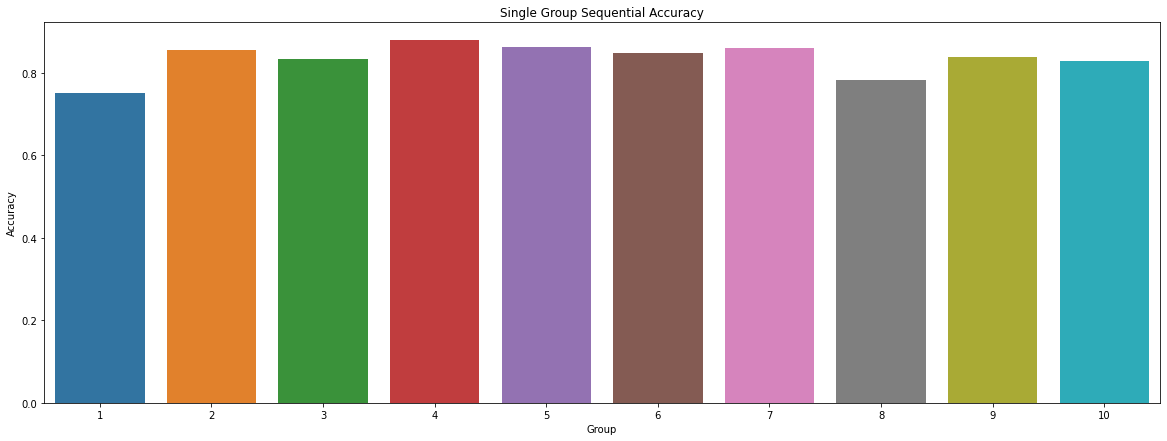

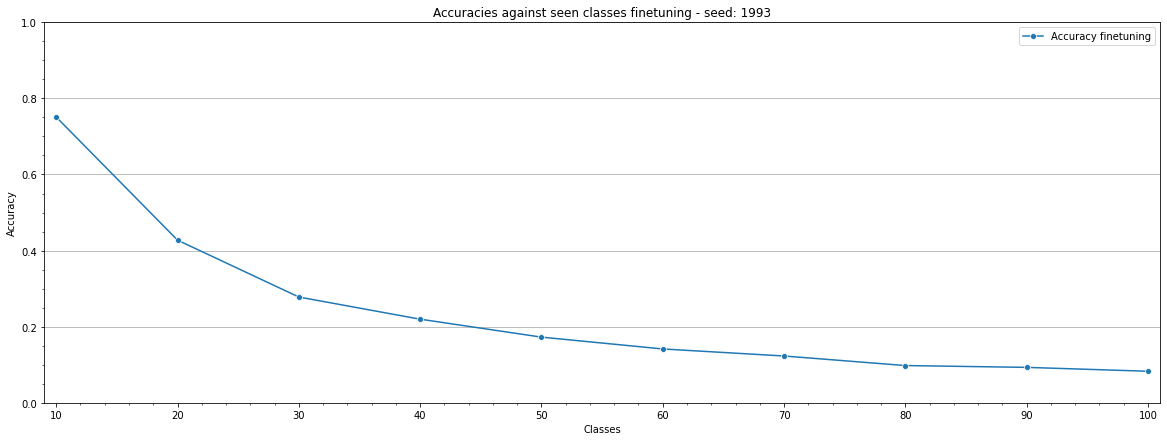

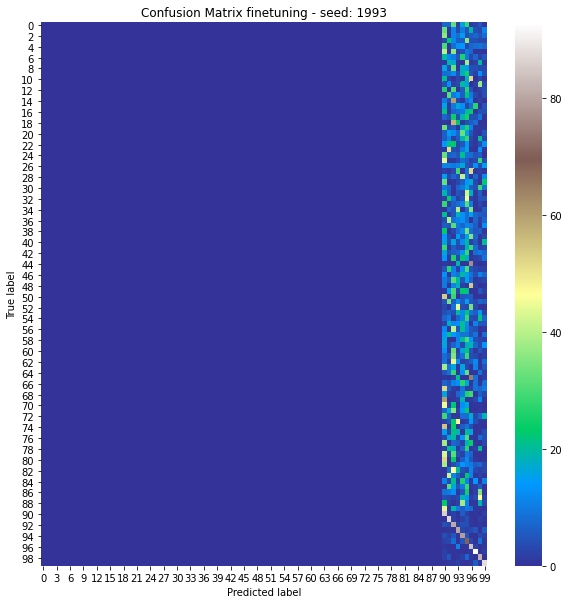

NameError: ignored

In [ ]:
method = "finetuning"
print("metrics FINETUNING for seed {}".format(RANDOM_SEED))

data_plot_bar=[]
data_plot_line=[]
for id in range(0,10):
    data_plot_bar.append((id+1,old_accuracies[id]))
    data_plot_line.append(((id+1)*10,new_accuracies[id]))

plt.figure(figsize=(20,7))
accuracyDF=pd.DataFrame(data_plot_bar, columns = ['Group','Accuracy'])
ax = sns.barplot(x="Group", y="Accuracy",data=accuracyDF)
plt.title("Single Group Sequential Accuracy")
plt.show()

# plot accuracy trend
plotAccuracyTrend(method, data_plot_line, RANDOM_SEED)

# confusion matrix
confusionMatrixData = confusion_matrix(all_labels_cm, all_preds_cm)
plotConfusionMatrix(method, confusionMatrixData, RANDOM_SEED)

# write down json
writeMetrics(method, RANDOM_SEED, accuracies, confusionMatrixData)

## LWF

### train, validate, test

In [ ]:
import copy
def train(net, train_dataloader, criterion, optimizer, scheduler, num_classes, group_id, old_net, num_epochs=NUM_EPOCHS):    
    num_classes_till_previous_step = group_id * 10 - 10

    # network to GPU
    net = net.to(DEVICE) 

    cudnn.benchmark

    current_step = 0
    # Start iterating over the epochs
    start_time = time.time()
    for epoch in range(num_epochs):
        net.train()
        print('Starting epoch {}/{}, LR = {}'.format(epoch+1, num_epochs, scheduler.get_lr()))

        running_corrects = 0
        running_loss = 0.0
        for _, images, labels in train_dataloader:

            # Bring images and labels to GPU
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Labels encoding 
            labels_enc = _one_hot_encode(labels, num_classes, outputs_labels_mapping)
            labels = outputs_labels_mapping.getNodes(labels)

            optimizer.zero_grad()

            # Forward pass
            features = net.forward(images)
            outputs = net.predict(features)

            # if iteration > 0, loss is the combination between the classification loss on new classes and the distillation loss on old classes
            if (group_id > 1):
              old_features = old_net.forward(images)
              old_outputs = old_net.predict(old_features)
              labels_enc[:,0:num_classes_till_previous_step] = torch.sigmoid(old_outputs)

            loss = computeLoss(criterion, outputs, labels_enc)
            
            # Get predictions
            _, preds = torch.max(outputs.data, 1)
            
            # Update Corrects & Loss
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data).data.item()

            # Log loss
            if current_step % LOG_FREQUENCY == 0:
                print('Train step - Step {}, Loss {}'.format(current_step, loss.item()))

            # Compute gradients for each layer and update weights
            loss.backward()  # backward pass: computes gradients
            optimizer.step() # update weights based on accumulated gradients

            current_step += 1
        
        # Step the scheduler
        scheduler.step()

        # Calculate Accuracy & Loss
        epoch_loss = running_loss / float(len(train_dataloader.dataset))
        epoch_acc = running_corrects / float(len(train_dataloader.dataset))
        
        print('Train epoch - Accuracy: {} Loss: {} Corrects: {}'.format(epoch_acc, epoch_loss, running_corrects))
    print('Training finished in {} seconds'.format(time.time() - start_time))

def validate(net, val_dataloader, criterion, num_classes):
    net.eval()

    getLossCriterion()

    all_preds_cm = []
    all_labels_cm = []

    running_corrects = 0
    running_loss = 0.0
    for _, images, labels in val_dataloader:

        # Bring images and labels to GPU
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
       
        # Labels encoding 
        labels_enc = _one_hot_encode(labels, num_classes, outputs_labels_mapping)
        labels = outputs_labels_mapping.getNodes(labels)

        # Forward pass to the network
        features = net.forward(images)
        outputs = net.predict(features)
        
        # Update Corrects & Loss
        if criterion is not None:
            loss = computeLoss(criterion, outputs, labels_enc)
            running_loss += loss.item() * images.size(0)

        _, preds = torch.max(outputs.data, 1)
        running_corrects += torch.sum(preds == labels.data).data.item()

        all_preds_cm.extend(preds.tolist())
        all_labels_cm.extend(labels.data.tolist())

    #Accuracy & Loss
    loss = running_loss / float(len(val_dataloader.dataset))
    acc = running_corrects / float(len(val_dataloader.dataset))

    return acc, loss, all_preds_cm, all_labels_cm

def test(net, test_dataloader, num_classes):
    acc, _, all_preds_cm, all_labels_cm = validate(net, test_dataloader, None, num_classes)
    return acc, np.array(all_preds_cm), np.array(all_labels_cm)

### sequential learning LWF

In [ ]:
### LWF
def sequentialLearningLWF(train_subsets, val_subsets, test_subsets):
    net, criterion, optimizer, scheduler = getResNet32()
    test_set = None
    groups_accuracies=[]
    all_accuracies=[]
    group_id=1


    for train_subset, val_subset, test_subset in zip(train_subsets, val_subsets, test_subsets):
      
      if test_set is None:
        test_set = test_subset
        old_net = copy.deepcopy(net)
        old_net.to(DEVICE)
        addOutputs(net,10)
      else:
        test_set = joinSubsets(test_dataset, [test_set, test_subset])
        old_net = copy.deepcopy(net)
        old_net.to(DEVICE)
        addOutputs(net,10)
      
      num_classes_per_group = 10
      num_classes_seen = group_id*10

      print("GROUP: ",group_id)
      # Train on current group
      optimizer, scheduler = getSchedulerOptimizer(net) # reset learning rate and step_size
      train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      train(net, train_loader, criterion, optimizer, scheduler, num_classes_seen, group_id, old_net)

      # Validate on current group
      val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc, loss, _, _ = validate(net, val_loader, criterion, num_classes_seen)
      print("EVALUATION: ",acc, loss)

      # Test on current group
      test_group_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc_group, _, _ = test(net, test_group_loader, num_classes_seen)
      groups_accuracies.append(acc_group)

      test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc_all, all_preds_cm, all_labels_cm = test(net, test_loader, num_classes_seen)
      all_accuracies.append(acc_all)
      
      print("TEST GROUP: ",acc_group)
      print("TEST ALL: ",acc_all)
      group_id+=1

    return net, groups_accuracies, all_accuracies, all_preds_cm, all_labels_cm

def printAccuracyDifference(net, old_accuracies):
    dif_accuracies=[]
    id_group=0
    for test_subset in test_subsets:
        test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
        acc = test(net, test_loader)
        dif_accuracies.append((id_group+1,old_accuracies[id_group],acc))
        id_group+=1
    return dif_accuracies

### execution

In [ ]:
# train
# net, old_accuracies, new_accuracies, all_preds_cm, all_labels_cm = sequentialLearningLWF(train_subsets, val_subsets, test_subsets)

### plot results

In [ ]:
method = "Learning Without Forgetting"
print("metrics FINETUNING for seed {}".format(RANDOM_SEED))

data_plot_bar=[]
data_plot_line=[]
for id in range(0,10):
    data_plot_bar.append((id+1,old_accuracies[id]))
    data_plot_line.append(((id+1)*10,new_accuracies[id]))

plt.figure(figsize=(20,7))
accuracyDF=pd.DataFrame(data_plot_bar, columns = ['Group','Accuracy'])
ax = sns.barplot(x="Group", y="Accuracy",data=accuracyDF)
plt.title("Single Group Sequential Accuracy")
plt.show()

# plot accuracy trend
plotAccuracyTrend(method, data_plot_line, RANDOM_SEED)

# confusion matrix
confusionMatrixData = confusion_matrix(all_labels_cm, all_preds_cm)
plotConfusionMatrix(method, confusionMatrixData, RANDOM_SEED)

# write down json
writeMetrics(method, RANDOM_SEED, accuracies, confusionMatrixData)

In [ ]:
"""num_classes_seen = 100
dif_accuracies=printAccuracyDifference(net,old_accuracies, num_classes_seen)
dif_accuracies"""

## iCaRL

### construct exemplar set

In [14]:
import sys

def constructExemplarSet(net, Xclass, m):
#Xclass contiene immagini e label della classe X
  exemplars_set = []
  feature_exemplars = []
  indexes = []
  features = [] 

  with torch.no_grad():
    XtrainLoader = torch.utils.data.DataLoader(Xclass, shuffle = True, batch_size=1, num_workers=2)
    for _, image, labels in XtrainLoader:
      image = image.to(DEVICE)
      # per ogni immagine della classe x, prendiamo le rispettive feature e le uniamo nel vettore features, che contiene tutte quelle delle immagini della classe x
      featuretmp = net.forward(image)
      feature = net.predict(featuretmp)
      #print(feature)
      feature.data = feature.data/feature.data.norm()
      features.append(feature)

    features = torch.cat(features, dim=0) #cat solve the problem of inequal size of tensors 
    current_class_mean = features.mean(0) # mu = media delle features delle immagini della classe

    for k in range(1, m+1):
      min = 100000
      sum = 0
      for j in range(k-1):
        sum += feature_exemplars[j]
      for x in range(len(Xclass)): 
        if (x not in indexes):
          phiX = features[x]
          val = current_class_mean - ((phiX + sum)/k)
          val = np.linalg.norm(val.cpu().numpy()) ## NORMA 
          #res = torch.lt(val, min)
        #res.sum() ritorna il numero di True 
          #sumTrue = res.sum() #sumTrue restituisce il numero di True all'interno del tensore Res 
          #lenghtTmp = res.shape # dimensione del tensore
          #lenght = list(lenghtTmp)[0]
          #res = (lenght == sumTrue)
          #trueLabel = torch.tensor(True).to(device)
          #if (torch.equal(trueLabel, res)):
          if (val < min):
            min = val
            feature_min = phiX
            index_min = x
      indexes.append(index_min)
      feature_exemplars.append(feature_min)
      exemplars_set.append(Xclass[index_min])

    print("lunghezza exemplar set: ", len(exemplars_set))
    return exemplars_set

### reduce exemplar set

In [15]:
# DA CHIAMARE PER OGNI CLASSE k: riduce il numero di exemplars all'interno dell'exemplar_set della classe k 
def reduceExemplarSet(m, exemplars_set):
  exemplars_new = []
  for i in range(m):
    exemplars_new.append(exemplars_set[i])

  return exemplars_new

### update representation

In [16]:
def updateRepresentation(net, train_subset, criterion, optimizer, scheduler, num_classes, group_id, K, exemplars_set_tot):
  #exemplars_set_tot contiene tutti gli exemplars set ottenuti fino ad ora
  #train_iter contiene tutti i dati (immagini + labels) delle classi nuove (s, .., t)
  
  for k, v in exemplars_set_tot.items():
    train_subset += v 
  train_loader = torch.utils.data.DataLoader(train_subset, shuffle = True, batch_size=BATCH_SIZE, num_workers=2)
  # train_loader è la concatenazione delle nuove classi con gli exemplar_sets calcolati fino a questo punto 
  print("training")
  train(net, train_loader, criterion, optimizer, scheduler, num_classes, group_id)

### incremental train

In [17]:
def incrementalTrain(net, train_subset, criterion, optimizer, scheduler, num_classes_seen, group_id, K, exemplars_set_tot):
  print("Starting the update reprensentation")
  num_classes = 10
  classes_until_now = []
  new_classes_examined = list(train_dataset.df.loc[train_subset.indices, 'labels'].value_counts().index)
 

  updateRepresentation(net, train_subset, criterion, optimizer, scheduler, num_classes, group_id, K, exemplars_set_tot)
                
  iteration = group_id - 1
  t = (num_classes * iteration) + num_classes # num_classes ricevute fino a questo momento 
  m = int(K/t) #casto ad intero ? per difetto o eccesso?
  s = num_classes * iteration

  print("reducing examplar for each class")
  for y in classes_until_now: #ci serve un set con tutte le classi fino ad ora viste
    exemplar_y_new = reduceExemplarSet(m, exemplars_set_tot[y]) # valore associato alla chiave y che rappresenta il label della classe 
    exemplars_set_tot[y] = exemplar_y_new
  
  classes_until_now.append(new_classes_examined)
  

  for y in new_classes_examined: # nuovi classi in arrivo di cui vogliamo costruire il set rappresentativo
    images_current_class = train_subset.dataset.df.loc[train_dataset.df['labels'] == y, 'data']
    imgs_idxs = images_current_class.index # the indexes of all the images in the current classe being considered 0...49k
    class_train_subset = Subset(train_dataset, imgs_idxs)#subset of the train dataset where i have all the imgs of class y
    print("class train: ", class_train_subset)
    print("Constructing exemplars of class", y)
    exemplars_set = constructExemplarSet(net,class_train_subset, m)
    exemplars_set_tot[y] = exemplars_set

### training

In [18]:
def train(net, train_dataloader, criterion, optimizer, scheduler, num_classes, group_id, num_epochs=NUM_EPOCHS):    
    num_classes_till_previous_step = group_id * 10 - 10

    # network to GPU
    net = net.to(DEVICE) 

    cudnn.benchmark

    current_step = 0
    # Start iterating over the epochs
    start_time = time.time()
    for epoch in range(num_epochs):
        net.train()
        print('Starting epoch {}/{}, LR = {}'.format(epoch+1, num_epochs, scheduler.get_lr()))

        running_corrects = 0
        running_loss = 0.0
        for _, images, labels in train_dataloader:

            # Bring images and labels to GPU
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Labels encoding 
            labels_enc = _one_hot_encode(labels, num_classes, outputs_labels_mapping)
            labels = outputs_labels_mapping.getNodes(labels)

            optimizer.zero_grad()

            # Forward pass
            features = net.forward(images)
            outputs = net.predict(features)

            # if iteration > 0, loss is the combination between the classification loss on new classes and the distillation loss on old classes
            if (group_id > 1):
              old_features = old_net.forward(images)
              old_outputs = old_net.predict(old_features)
              labels_enc[:,0:num_classes_till_previous_step] = torch.sigmoid(old_outputs)

            loss = computeLoss(criterion, outputs, labels_enc)
            
            # Get predictions
            _, preds = torch.max(outputs.data, 1)
            
            # Update Corrects & Loss
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data).data.item()

            # Log loss
            if current_step % LOG_FREQUENCY == 0:
                print('Train step - Step {}, Loss {}'.format(current_step, loss.item()))

            # Compute gradients for each layer and update weights
            loss.backward()  # backward pass: computes gradients
            optimizer.step() # update weights based on accumulated gradients

            current_step += 1
        
        # Step the scheduler
        scheduler.step()

        # Calculate Accuracy & Loss
        epoch_loss = running_loss / float(len(train_dataloader.dataset))
        epoch_acc = running_corrects / float(len(train_dataloader.dataset))
        
        print('Train epoch - Accuracy: {} Loss: {} Corrects: {}'.format(epoch_acc, epoch_loss, running_corrects))
    print('Training finished in {} seconds'.format(time.time() - start_time))

### test and validate

In [19]:
def validate(net, val_dataloader, criterion, num_classes):
    net.eval()

    getLossCriterion()

    all_preds_cm = []
    all_labels_cm = []

    running_corrects = 0
    running_loss = 0.0
    for _, images, labels in val_dataloader:

        # Bring images and labels to GPU
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
       
        # Labels encoding 
        labels_enc = _one_hot_encode(labels, num_classes, outputs_labels_mapping)
        labels = outputs_labels_mapping.getNodes(labels)

        # Forward pass to the network
        features = net.forward(images)
        outputs = net.predict(features)
        
        # Update Corrects & Loss
        if criterion is not None:
            loss = computeLoss(criterion, outputs, labels_enc)
            running_loss += loss.item() * images.size(0)

        _, preds = torch.max(outputs.data, 1)
        running_corrects += torch.sum(preds == labels.data).data.item()

        all_preds_cm.extend(preds.tolist())
        all_labels_cm.extend(labels.data.tolist())

    #Accuracy & Loss
    loss = running_loss / float(len(val_dataloader.dataset))
    acc = running_corrects / float(len(val_dataloader.dataset))

    return acc, loss, all_preds_cm, all_labels_cm

def test(net, test_dataloader, num_classes):
    acc, _, all_preds_cm, all_labels_cm = validate(net, test_dataloader, None, num_classes)
    return acc, np.array(all_preds_cm), np.array(all_labels_cm)

### main

In [20]:
# # MAIN quello che facevamo prima
# K = 2000
# iterations = 10
# num_classes = 10
# test_set = [] #initialized here because we test over all the classes not only those one in which I train
# exemplars_set_tot = {new_list: [] for new_list in range(100)}
# for i in range(iterations):
#   # train_subsets, val_subsets, test_subsets

#   valid_loader = torch.utils.data.DataLoader(val_subsets, shuffle = True, batch_size = batch_size, num_workers=2) 
#   print("Train the network, iteration: ", i, " on classes: ", classes_current_iter)
#   incrementalTrain(train_subsets, i, net, device, epochs, num_classes, K, exemplars_set_tot) # Train the network with 10 classes at a time
#   test(test_subsets, i, net) # Test the network with all classes seen until this iteration

In [21]:
def sequentialLearningiCaRL(train_subsets, val_subsets, test_subsets):
    net, criterion, optimizer, scheduler = getResNet32()
    test_set = None
    groups_accuracies=[]
    all_accuracies=[]
    group_id=1

    K = 2000
    iterations = 10
    num_classes = 10
    exemplars_set_tot = {new_list: [] for new_list in range(100)}
    

    for train_subset, val_subset, test_subset in zip(train_subsets, val_subsets, test_subsets):
      
      if test_set is None:
        test_set = test_subset
        addOutputs(net,10)
      else:
        test_set = joinSubsets(test_dataset, [test_set, test_subset])
        addOutputs(net,10)
      
      num_classes_per_group = 10
      num_classes_seen = group_id*10

      print("GROUP: ",group_id)
      # Train on current group
      optimizer, scheduler = getSchedulerOptimizer(net) # reset learning rate and step_size
      # train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      # train(net, train_loader, criterion, optimizer, scheduler, num_classes_seen, group_id, old_net)
      incrementalTrain(net, train_subset, criterion, optimizer, scheduler, num_classes_seen, group_id, K, exemplars_set_tot) # Train the network with 10 classes at a time

      # Validate on current group
      val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc, loss, _, _ = validate(net, val_loader, criterion, num_classes_seen)
      print("EVALUATION: ",acc, loss)

      # Test on current group
      test_group_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc_group, _, _ = test(net, test_group_loader, num_classes_seen)
      groups_accuracies.append(acc_group)

      test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc_all, all_preds_cm, all_labels_cm = test(net, test_loader, num_classes_seen)
      all_accuracies.append(acc_all)
      
      print("TEST GROUP: ",acc_group)
      print("TEST ALL: ",acc_all)
      group_id+=1

    return net, groups_accuracies, all_accuracies, all_preds_cm, all_labels_cm

def printAccuracyDifference(net, old_accuracies):
    dif_accuracies=[]
    id_group=0
    for test_subset in test_subsets:
        test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
        acc = test(net, test_loader)
        dif_accuracies.append((id_group+1,old_accuracies[id_group],acc))
        id_group+=1
    return dif_accuracies

In [22]:
# train
net, old_accuracies, new_accuracies, all_preds_cm, all_labels_cm = sequentialLearningiCaRL(train_subsets, val_subsets, test_subsets)

GROUP:  1
Starting the update reprensentation
training


RuntimeError: ignored